In [109]:
import os
import torch 
import argparse
import yaml
import wandb
from box import Box
import pandas as pd 
from math import pi 

from data.data_processing import DataProcessor
from models.models import LSTMModel,CNN_LSTMModel
from utils.utils import train, model_eval_metric,test


with open('config.yaml', 'r') as f:
    config = Box(yaml.safe_load(f))

# Data Processing
data_processor = DataProcessor(config)
data_processor.load_data()
data_processor.preprocess_data()

/home/robotics20/roboticstau/FMG_project/data/data_processing.py:59: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  self.data[self.config.fmg_index] = self.data[self.config.fmg_index].rolling(window=self.config.window_size, axis=0).mean()
/home/robotics20/roboticstau/FMG_project/data/data_processing.py:60: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  self.data[self.labal_index] = self.data[self.labal_index].rolling(window=self.config.window_size, axis=0).mean()


In [78]:

data = data_processor.data


In [79]:
import numpy as np
import numpy as np

def calculate_vectors(data):
    M1 = data[['M1x', 'M1y', 'M1z']].values
    M2 = data[['M2x', 'M2y', 'M2z']].values
    M3 = data[['M3x', 'M3y', 'M3z']].values
    M4 = data[['M4x', 'M4y', 'M4z']].values
    CtoS = M1 - M2
    StoE = M4 - M1
    EtoW = M3 - M4
    return CtoS, StoE, EtoW

def calculate_euler_angles(StoE, CtoS):
    # Normalizing the vectors
    StoE_normalized = StoE / np.linalg.norm(StoE)
    CtoS_normalized = CtoS / np.linalg.norm(CtoS)

    # Calculate local 'right' direction (perpendicular to StoE and CtoS)
    local_right = np.cross(StoE_normalized, CtoS_normalized)

    # Calculate local 'up' direction (perpendicular to StoE and local 'right')
    local_up = np.cross(local_right, StoE_normalized)

    # Pitch is the angle between StoE and the world Z-axis
    pitch = np.arcsin(-StoE_normalized[1])
    # Yaw is the angle between the projection of StoE in the world X-Y plane and the world X-axis
    yaw = np.arctan2(StoE_normalized[0], StoE_normalized[2])
    # Roll is the angle between the local 'up' and the world Z-axis
    roll = np.arctan2(local_up[0], local_up[2])

    return roll, pitch, yaw

def angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    magnitude_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    angle_rad = np.arccos(dot_product / magnitude_product)
    return angle_rad

def calculate_angles_with_axes(vectors, unit_vectors):
    angles = {axis: [] for axis in unit_vectors}  # Initialize as a dictionary of lists

    for vector in vectors:
        vector = np.array(vector)
        vector_magnitude = np.linalg.norm(vector)

        # Check for zero magnitude to avoid division by zero
        if vector_magnitude == 0:
            for axis in unit_vectors:
                angles[axis].append(0)
            continue

        for axis, unit_vector in unit_vectors.items():
            dot_product = np.dot(vector, unit_vector)
            # Clamp the value to the valid range for arccos to avoid numerical errors
            cos_angle = np.clip(dot_product / vector_magnitude, -1, 1)
            angle_rad = np.arccos(cos_angle)
            angles[axis].append(np.degrees(angle_rad))
    
    return angles

# Calculating vectors
CtoS, StoE, EtoW = calculate_vectors(data)

# Unit vectors for the reference frame
unit_vectors = {
    'X-axis': np.array([1, 0, 0]),
    'Y-axis': np.array([0, 1, 0]),
    'Z-axis': np.array([0, 0, 1])
}

In [80]:
def angle_between_vectors(v1, v2):
    dot_products = np.einsum('ij,ij->i', v1, v2)
    magnitudes = np.linalg.norm(v1, axis=1) * np.linalg.norm(v2, axis=1)
    angles_rad = np.arccos(np.clip(dot_products / magnitudes, -1.0, 1.0))
    return angles_rad

def calculate_euler_angles(StoE, CtoS):
    # Normalize the vectors
    StoE_normalized = StoE / np.linalg.norm(StoE, axis=1)[:, np.newaxis]
    CtoS_normalized = CtoS / np.linalg.norm(CtoS, axis=1)[:, np.newaxis]

    # Calculate local 'right' direction (perpendicular to StoE and CtoS)
    local_right = np.cross(StoE_normalized, CtoS_normalized)

    # Calculate local 'up' direction (perpendicular to StoE and local 'right')
    local_up = np.cross(local_right, StoE_normalized)

    # Calculate pitch, yaw, and roll
    pitch = np.arcsin(-StoE_normalized[:, 1])
    yaw = np.arctan2(StoE_normalized[:, 0], StoE_normalized[:, 2])
    roll = np.arctan2(local_up[:, 0], local_up[:, 2])

    return np.column_stack((roll, pitch, yaw))

(99959, 3)

In [89]:
StoE_angles =calculate_angles_with_axes(StoE, unit_vectors)
StoE_to_EtoW_angle = angle_between_vectors(StoE,EtoW)


In [116]:
StoE_angles_df = pd.DataFrame(StoE_angles)
StoE_to_EtoW_angle_df = pd.DataFrame(StoE_to_EtoW_angle,columns=['rad'])


In [117]:
StoE_to_EtoW_angle_df


,rad
0,2.067676
1,2.067809
2,2.067934
3,2.068052
4,2.068164
...,...
99954,0.880061
99955,0.892067
99956,0.904465
99957,0.917301


In [99]:
StoE_angles_df = np.radians(StoE_angles_df)


<Axes: >

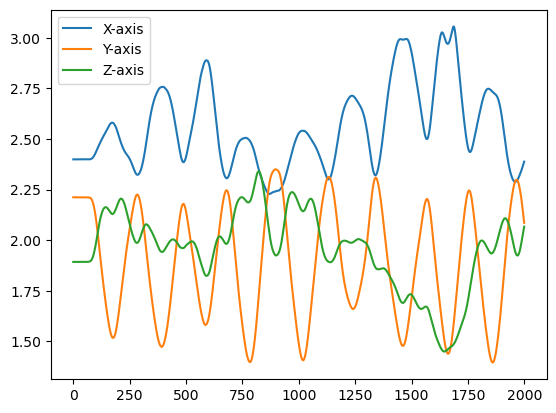

In [113]:
StoE_angles_df[:2000].plot(

)


In [110]:
(StoE_angles_df > pi).any()


X-axis    False
Y-axis    False
Z-axis    False
dtype: bool

In [111]:
StoE_angles_df.to_csv(r'StoE_angles.csv')
StoE_to_EtoW_angle_df.to_csv(r'StoE_to_EtoW_angle.csv')
